# E2. SLAM

### Define all the imports
Import all the dependencies required to launch the notebook

In [1]:
# Import main dependencies
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
# Ignore warnings from pandas
pd.set_option('mode.chained_assignment', None)

In [3]:
# Import methods from our local library
from src.EKF_SLAM.EKF_SLAM_known_correspondences import ExtendedKalmanFilterSLAM as EKF_SLAM

from src.fast_SLAM_1.Fast_SLAM_1_known_correspondences import FastSLAM1 as FastSLAM
from src.fast_SLAM_1.lib import MotionModel as FS_MotionModel
from src.fast_SLAM_1.lib import MeasurementModel as FS_MeasurementModel

from src.graph_SLAM.Graph_SLAM_known_correspondences import GraphSLAM

### Set dataset

In [4]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset4"
robot = 'Robot4' # Robot
start_frame = 2000
end_frame = 5000

### T1. Review EKF SLAM
Review the EKF_SLAM() method, execute the EKF SLAM of the next code block, and answer the questions below:

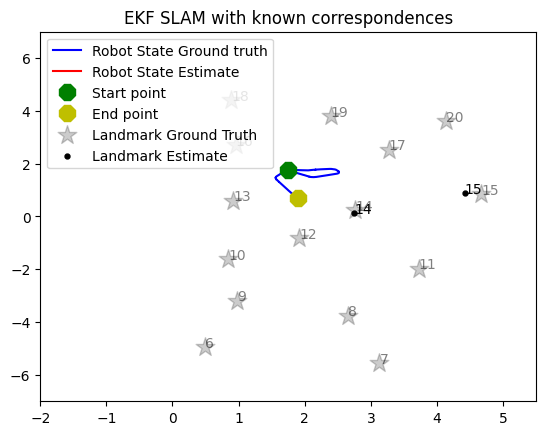

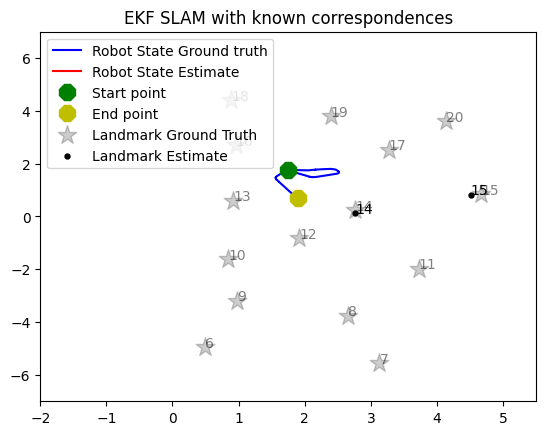

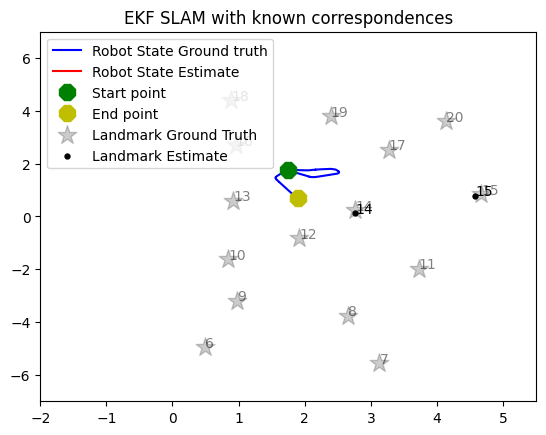

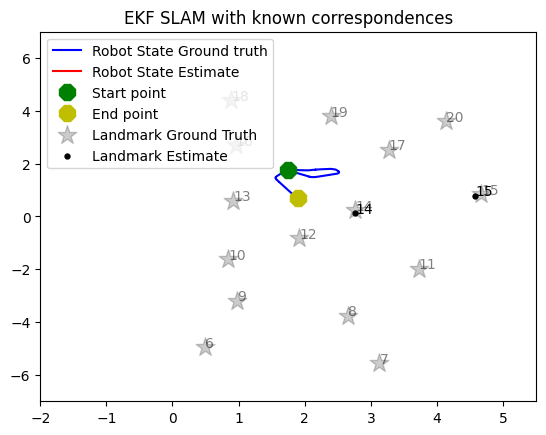

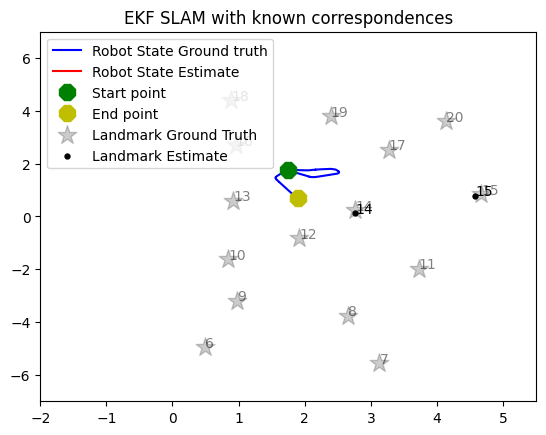

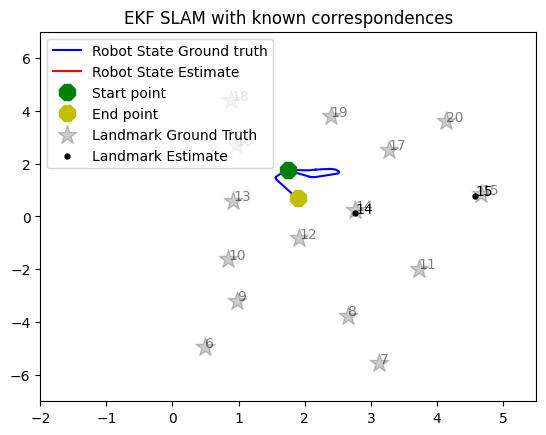

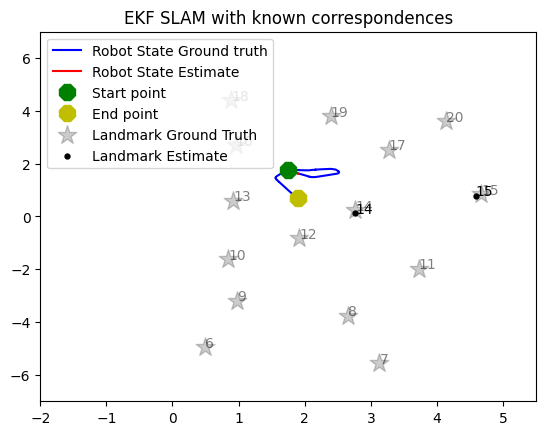

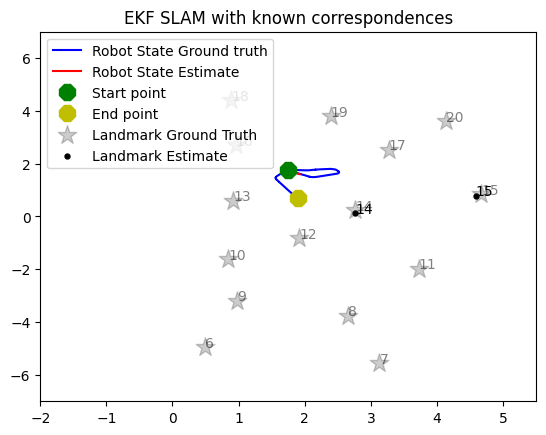

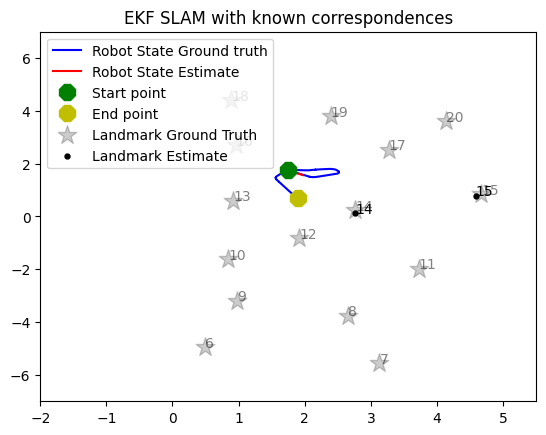

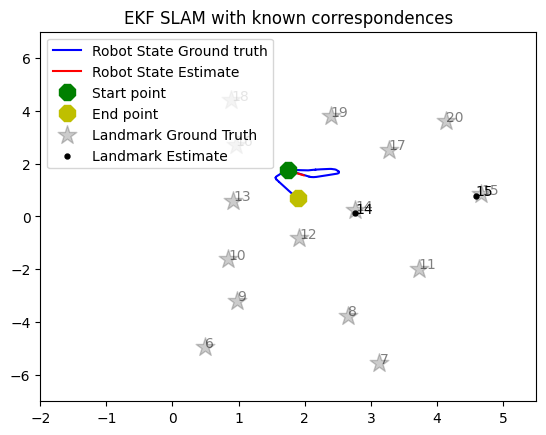

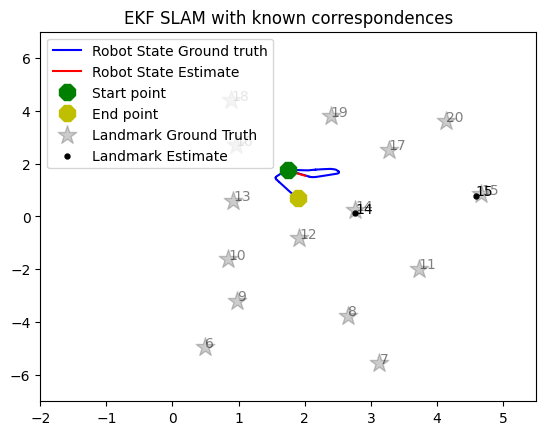

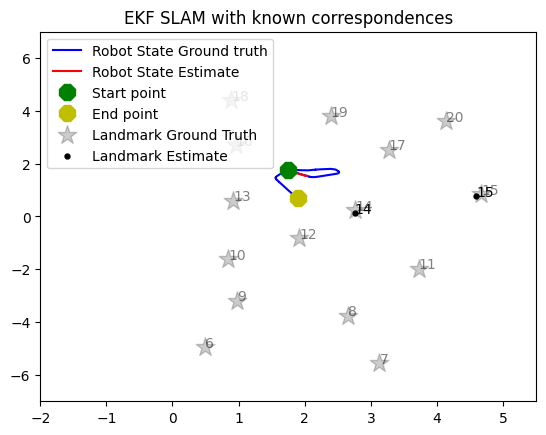

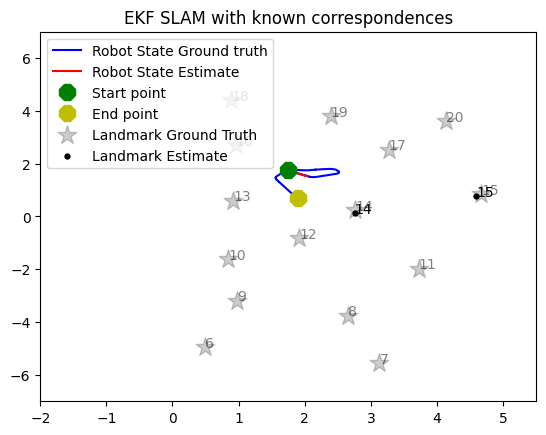

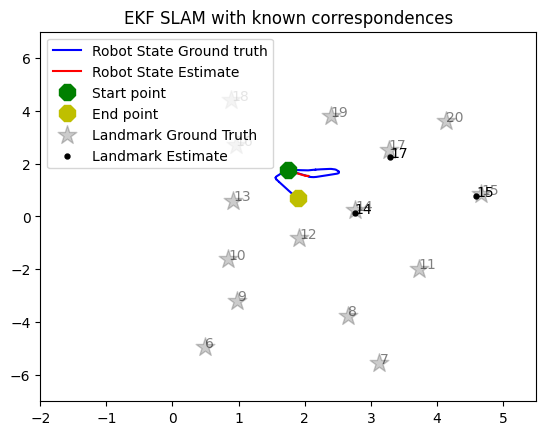

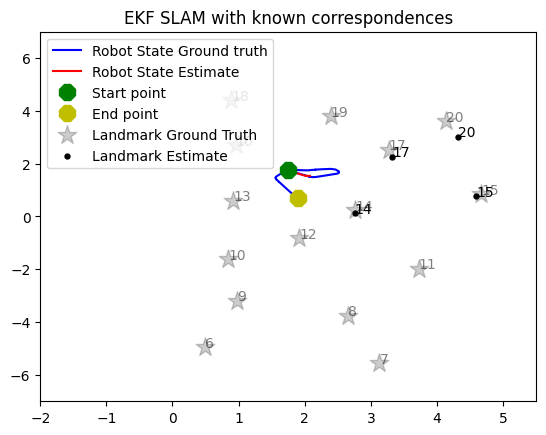

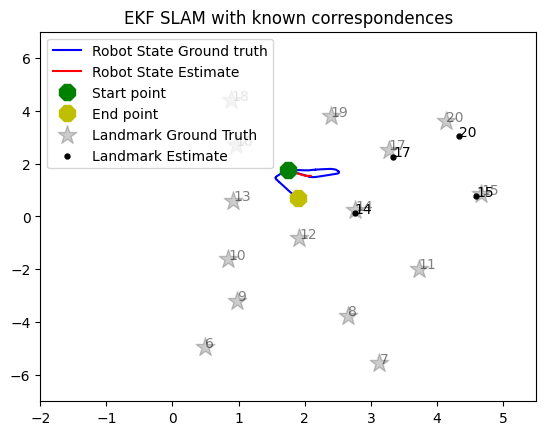

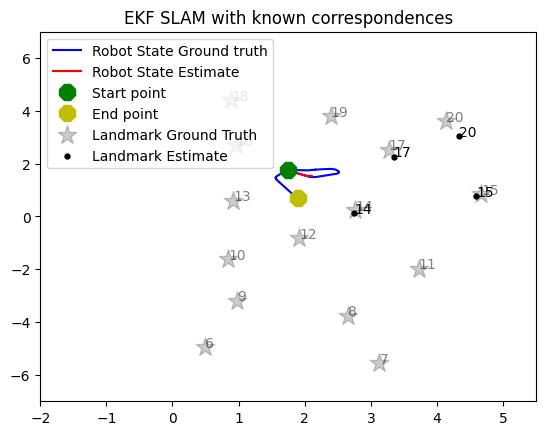

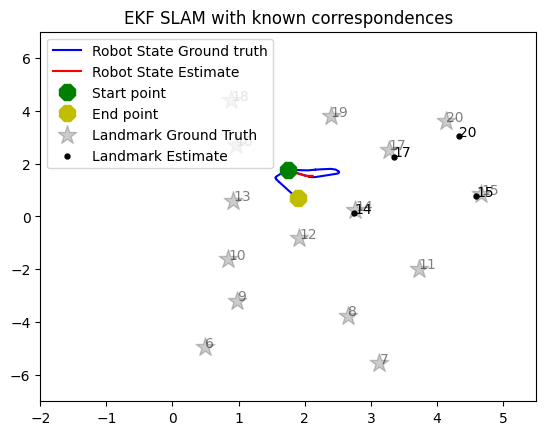

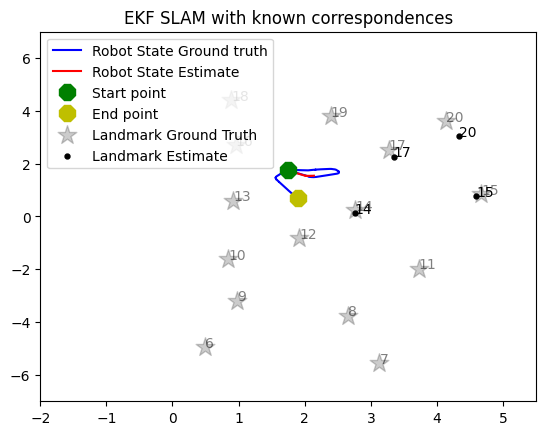

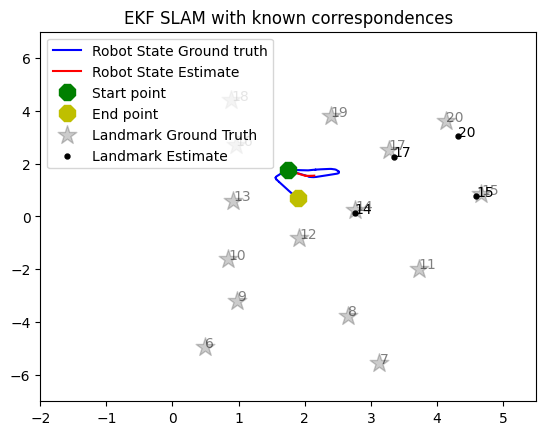

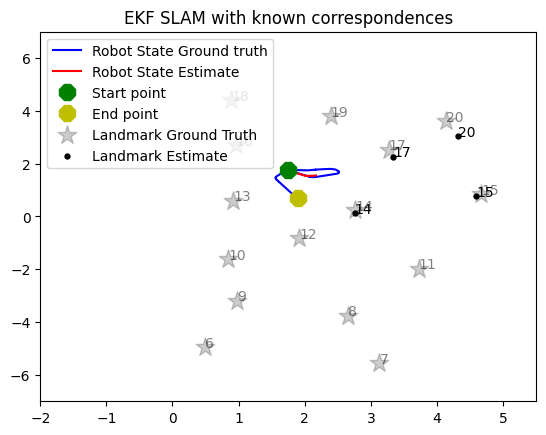

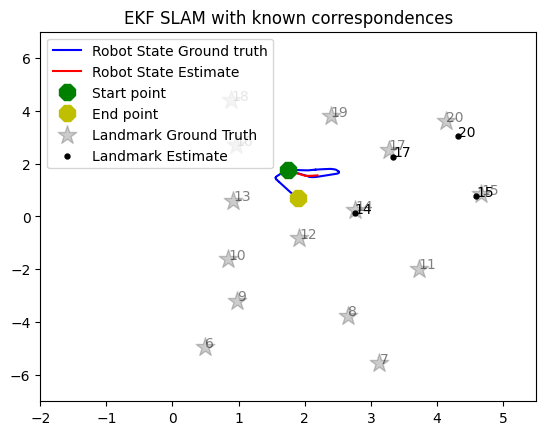

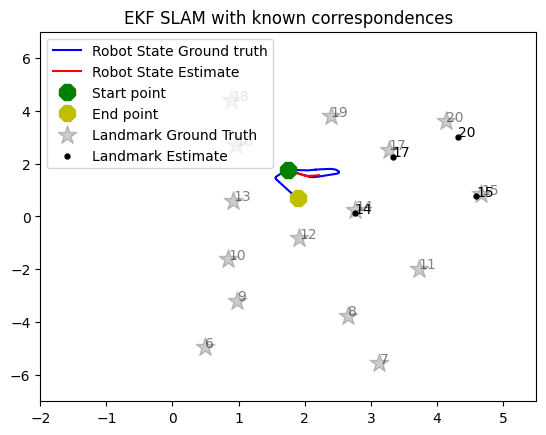

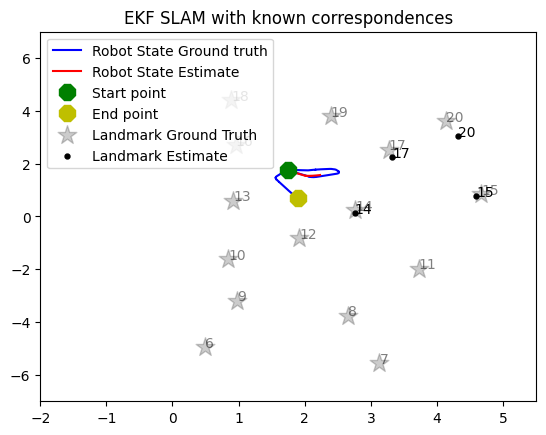

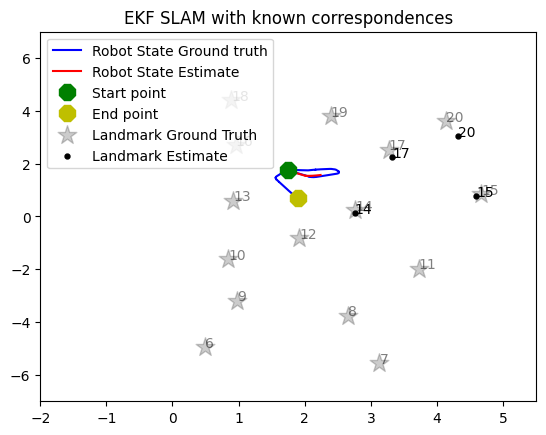

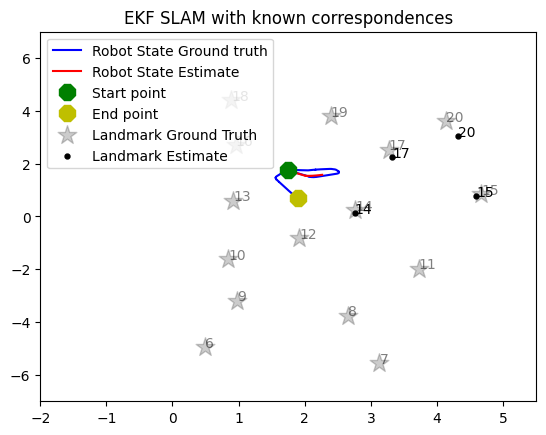

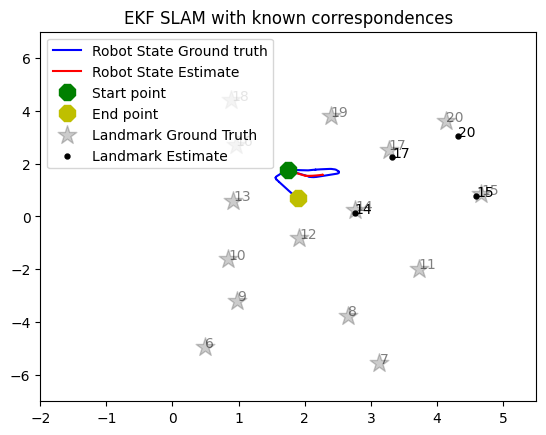

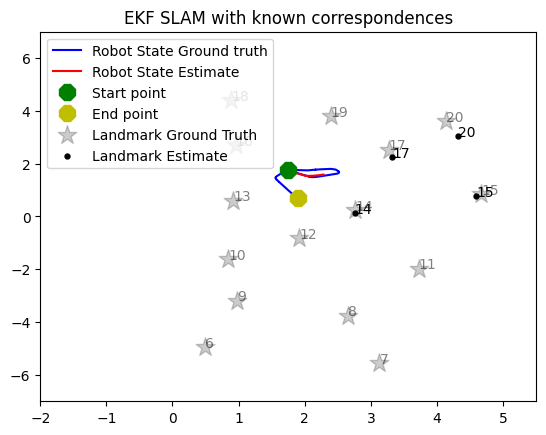

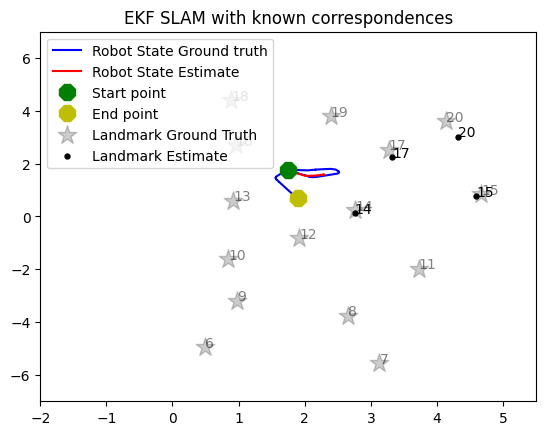

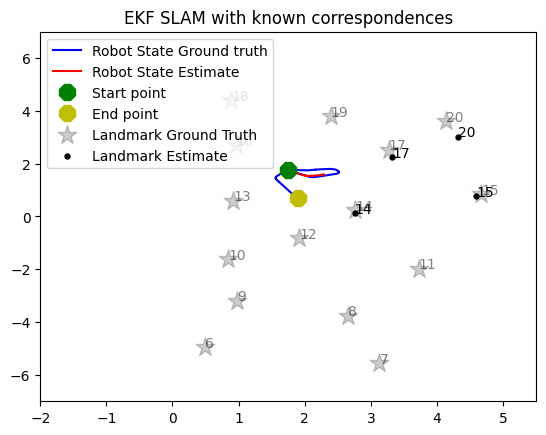

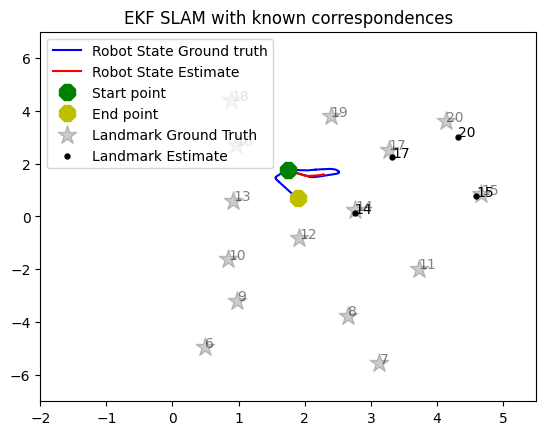

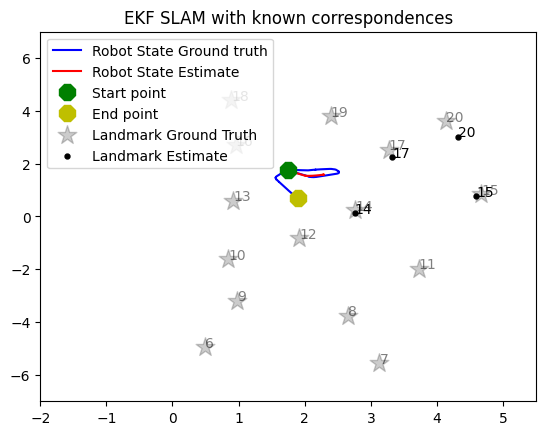

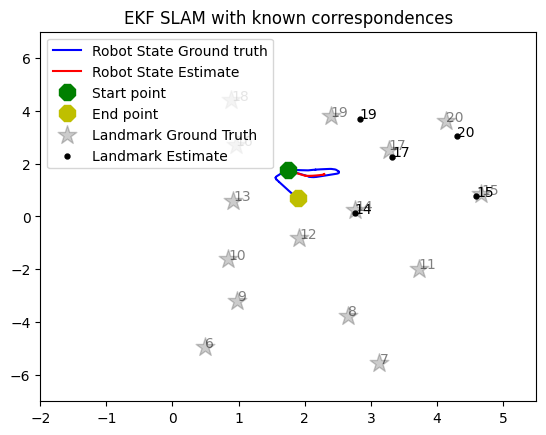

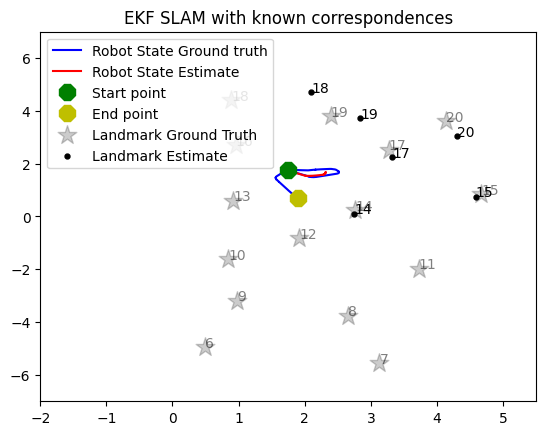

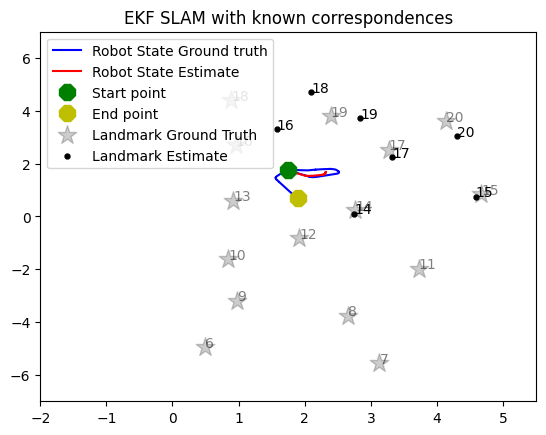

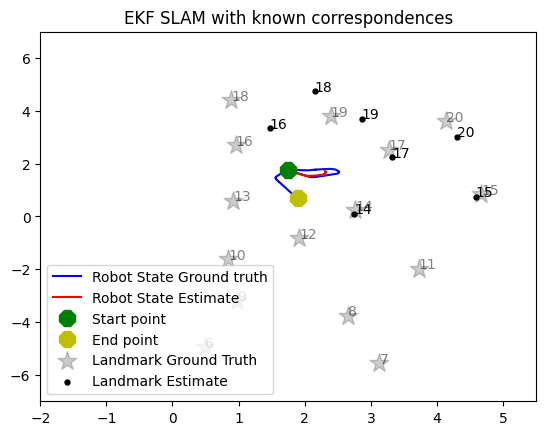

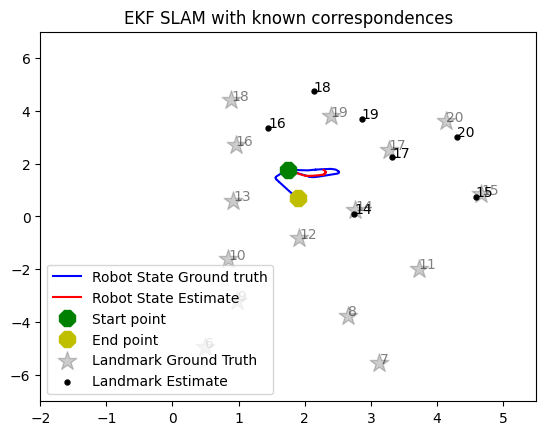

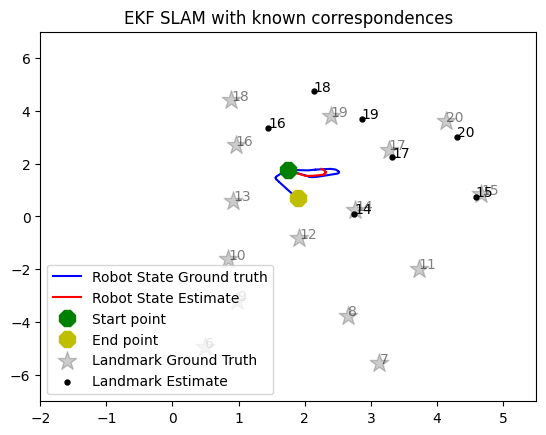

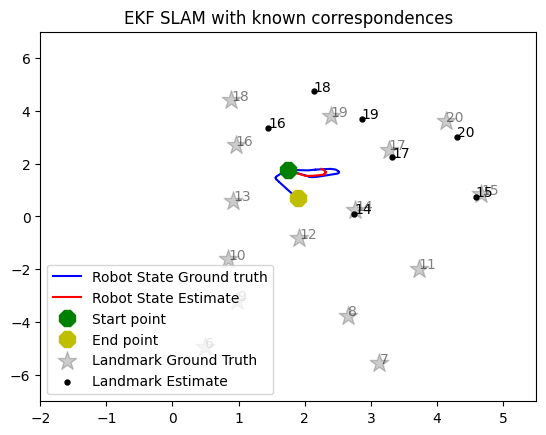

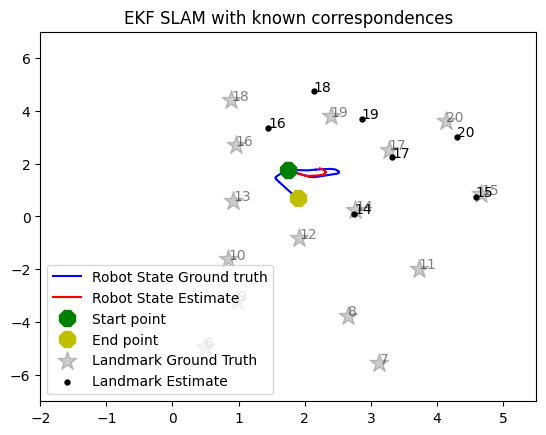

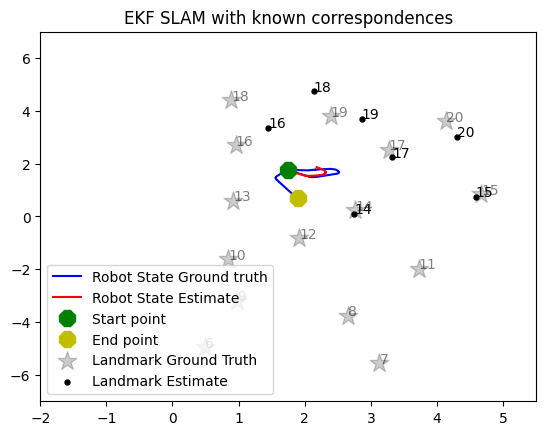

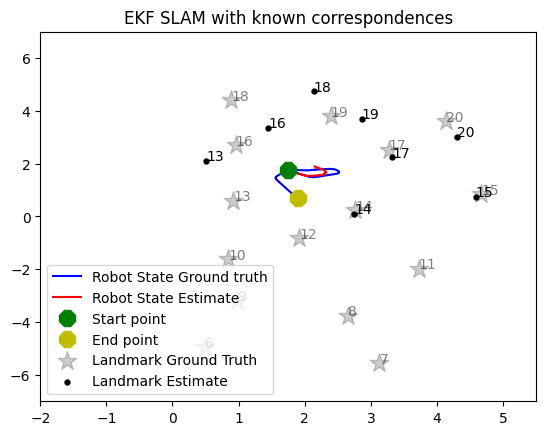

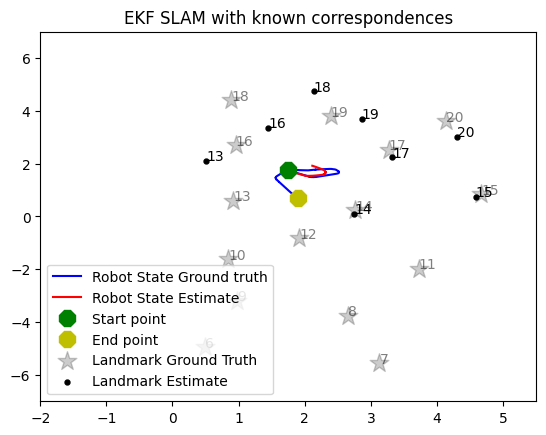

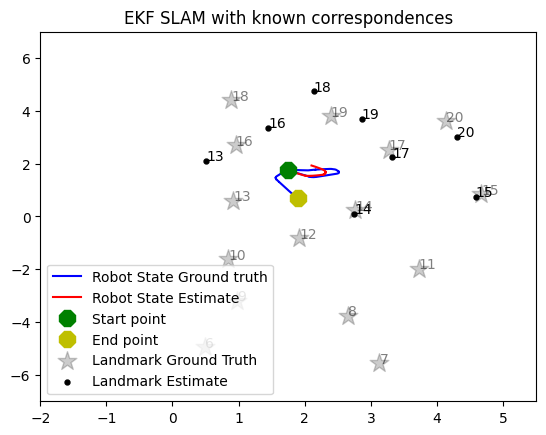

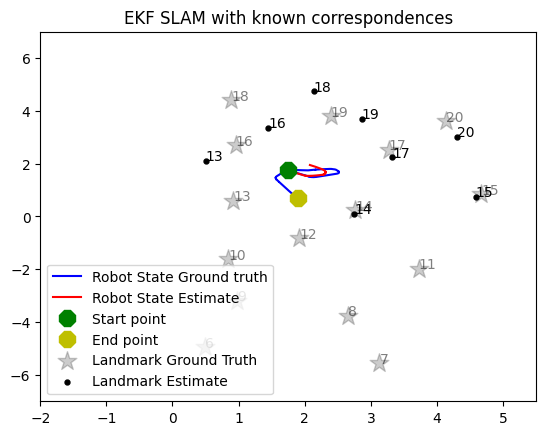

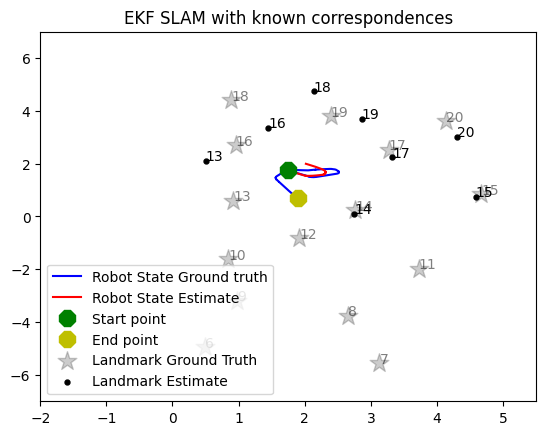

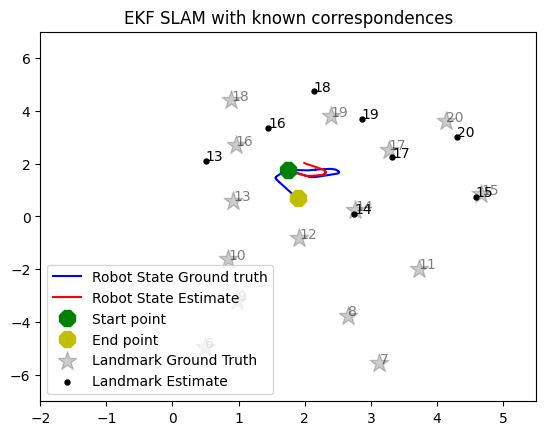

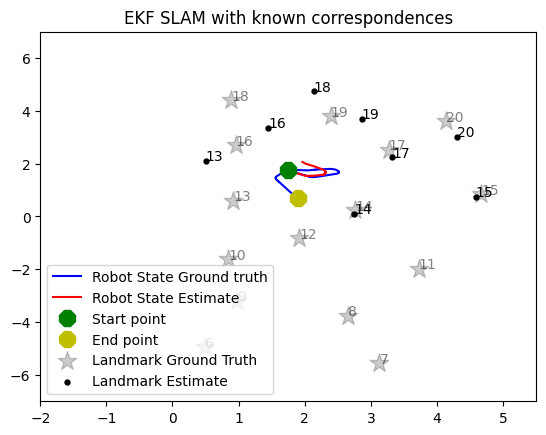

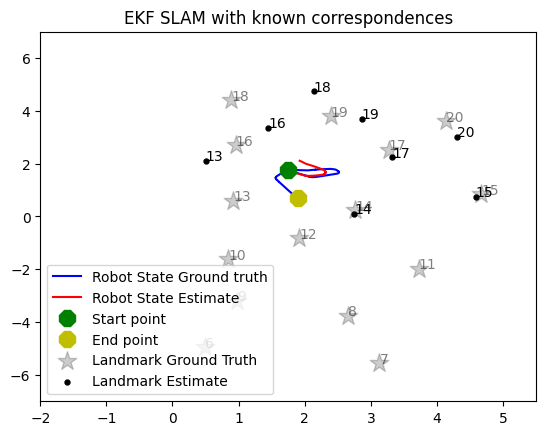

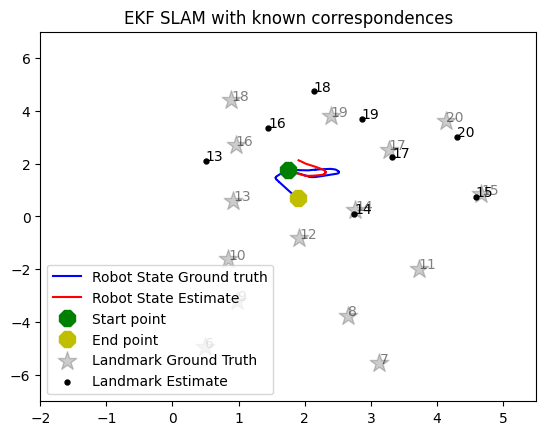

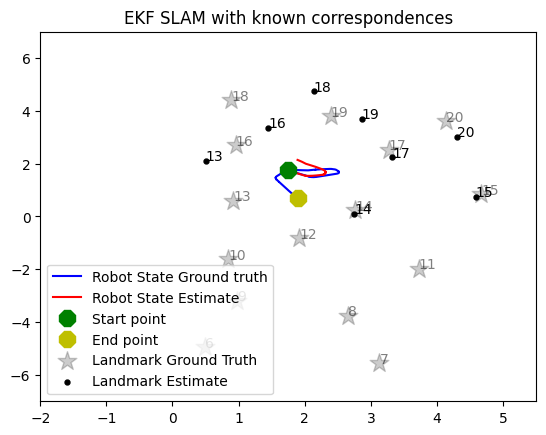

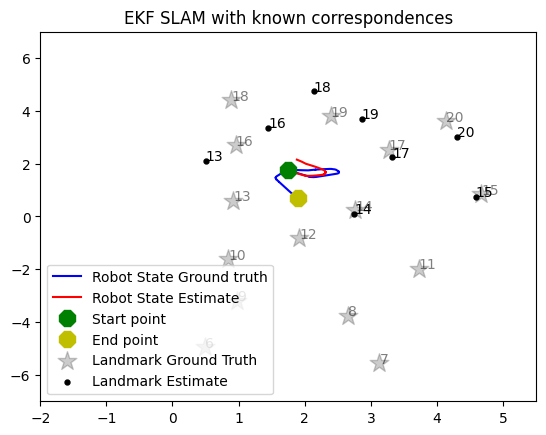

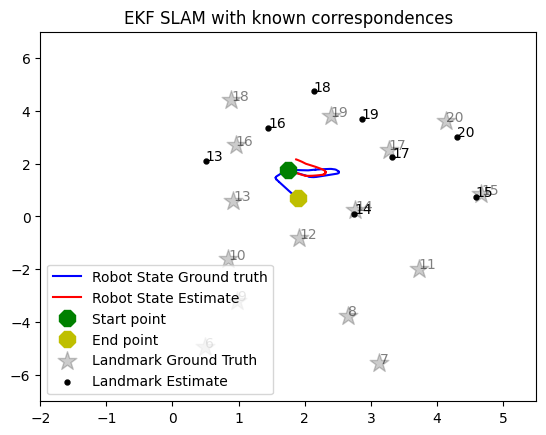

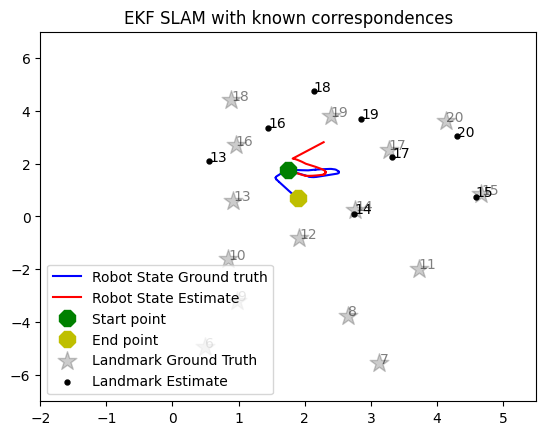

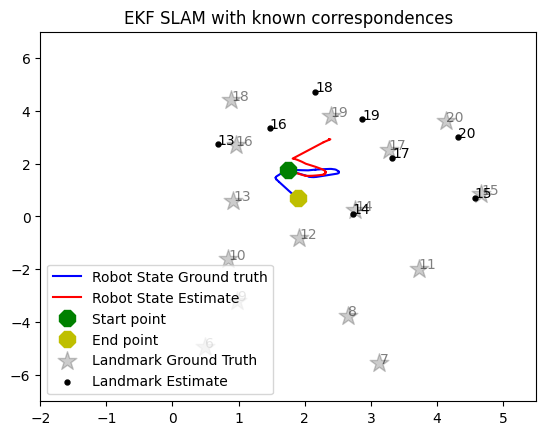

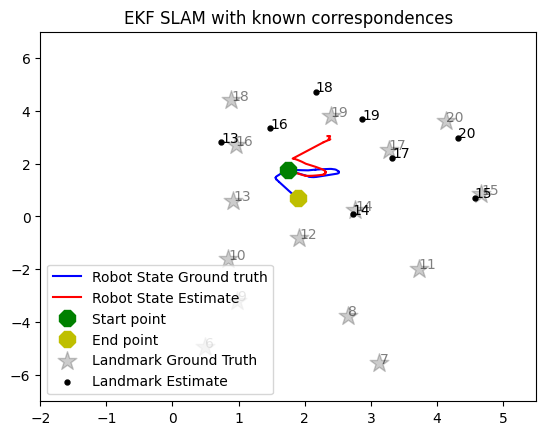

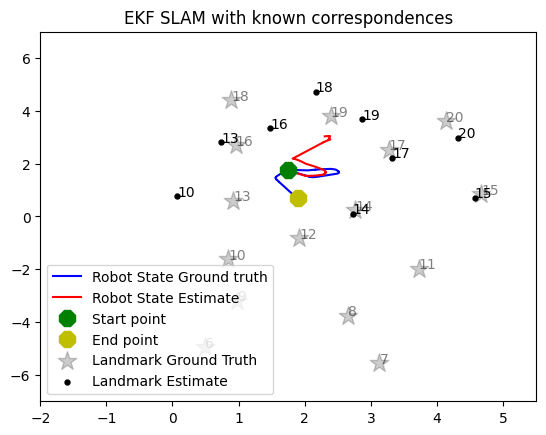

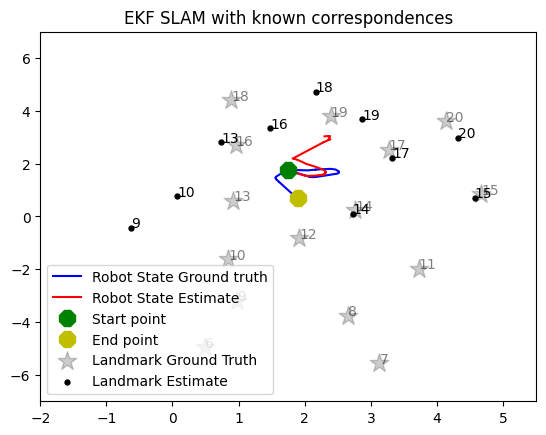

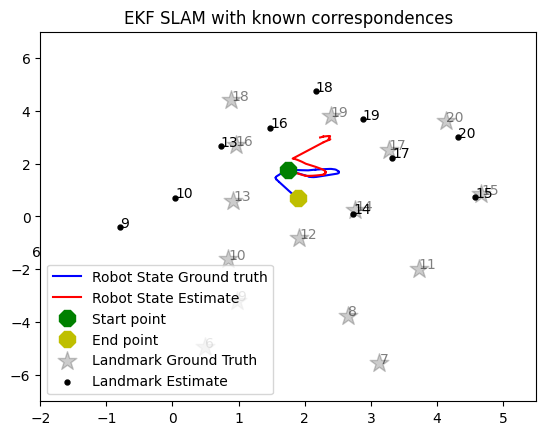

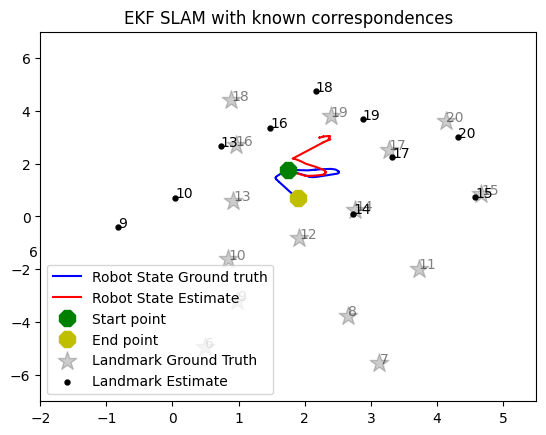

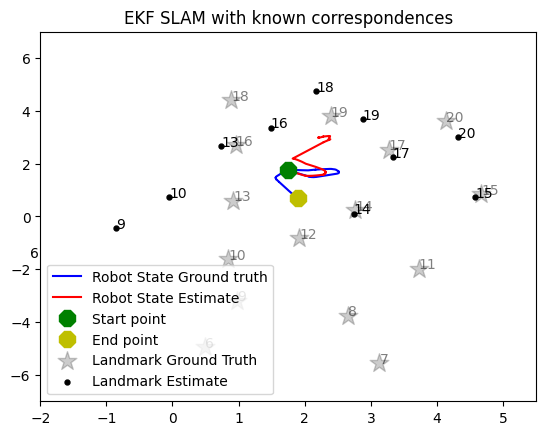

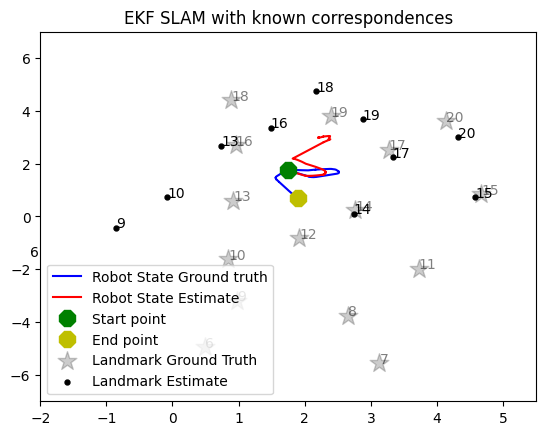

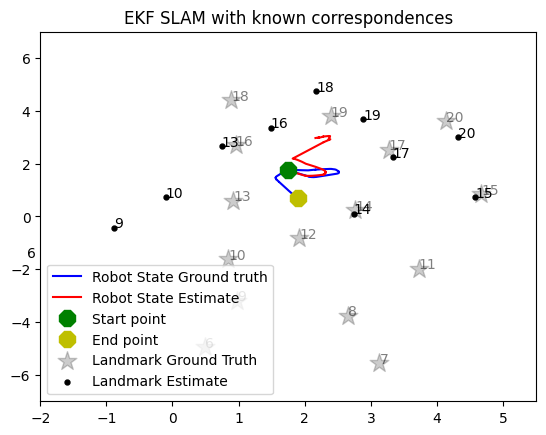

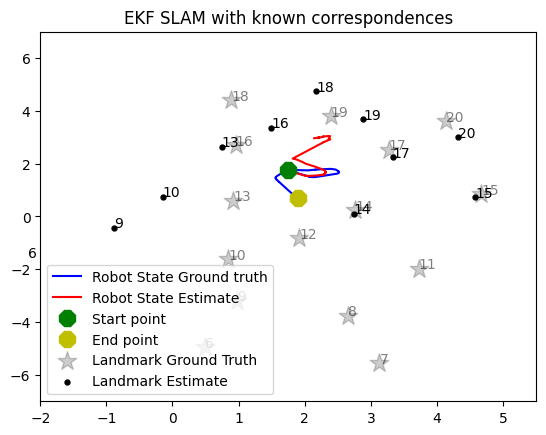

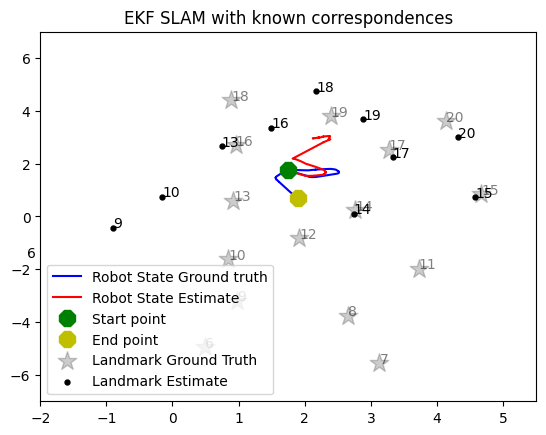

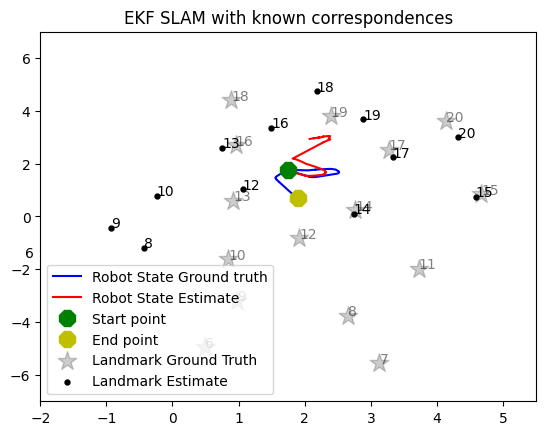

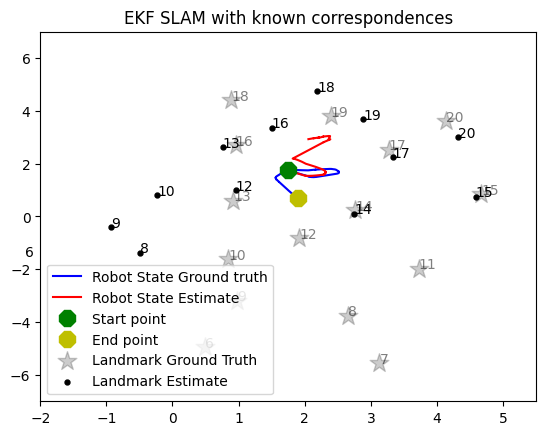

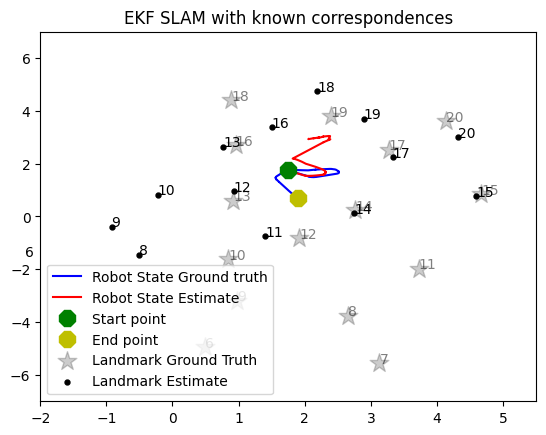

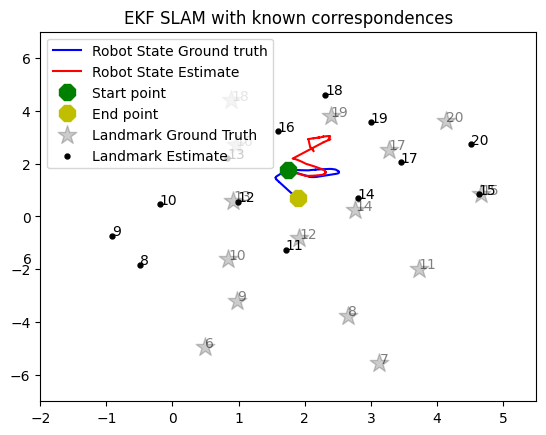

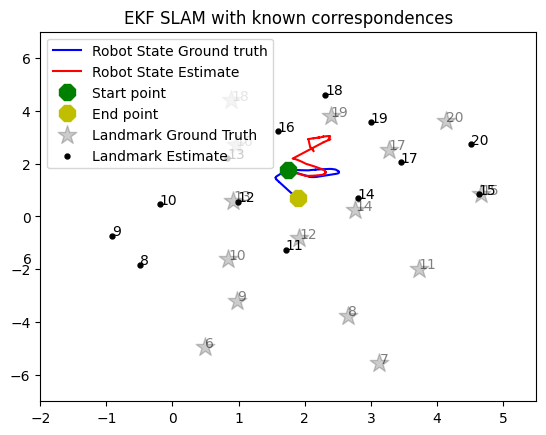

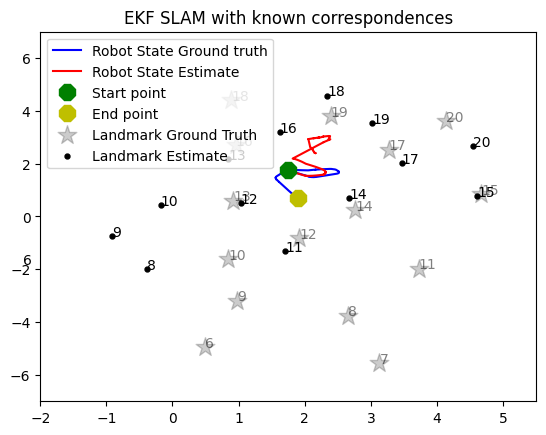

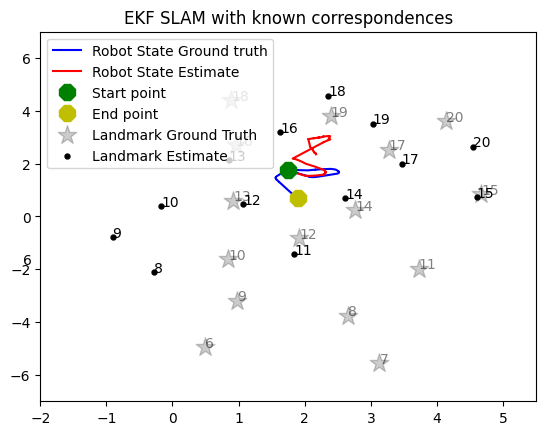

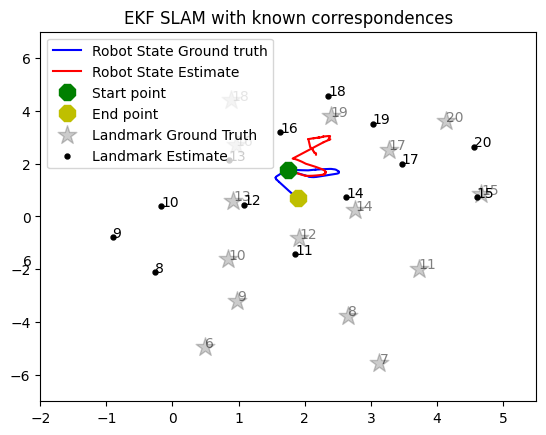

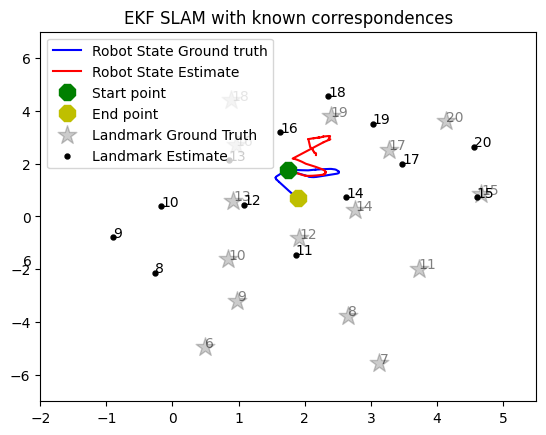

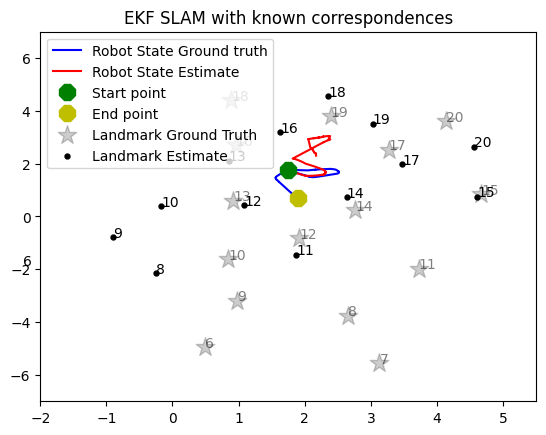

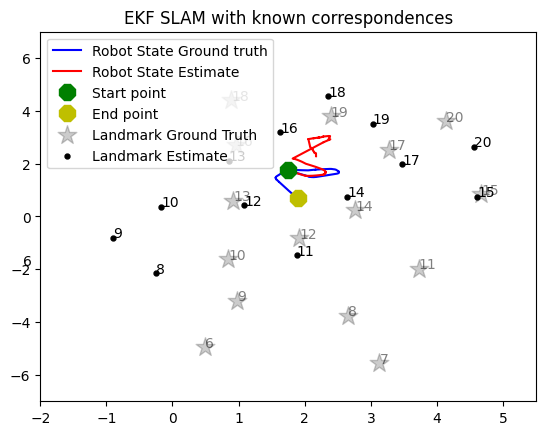

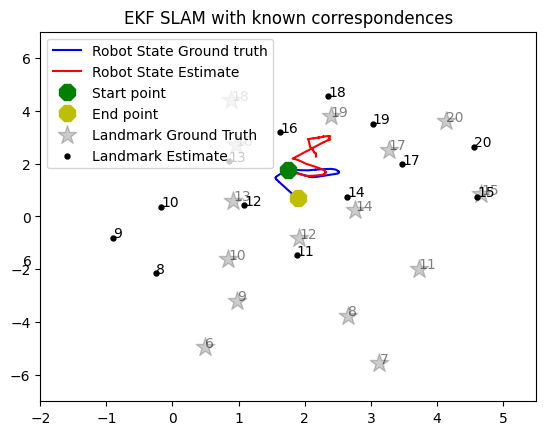

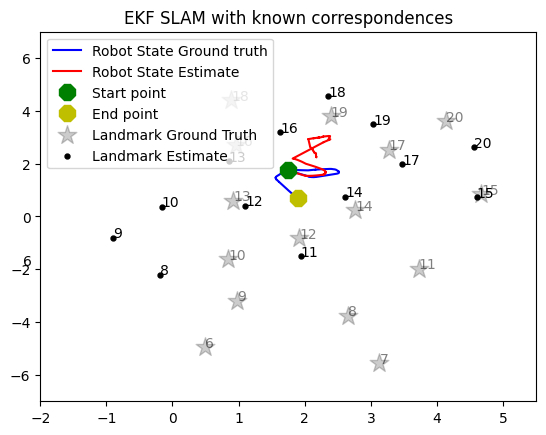

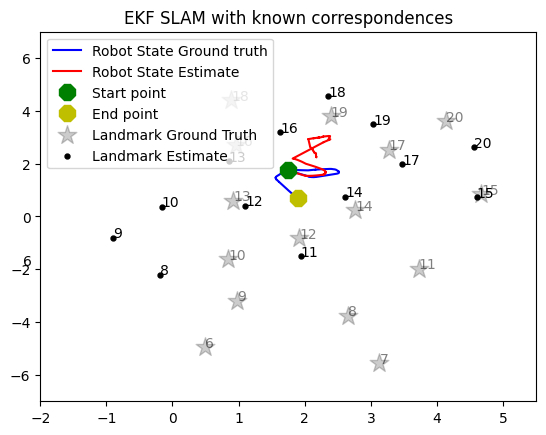

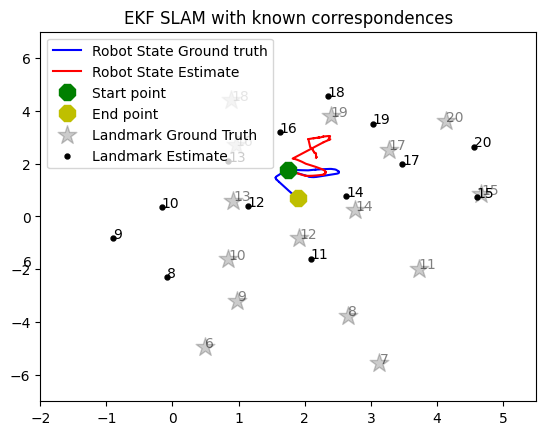

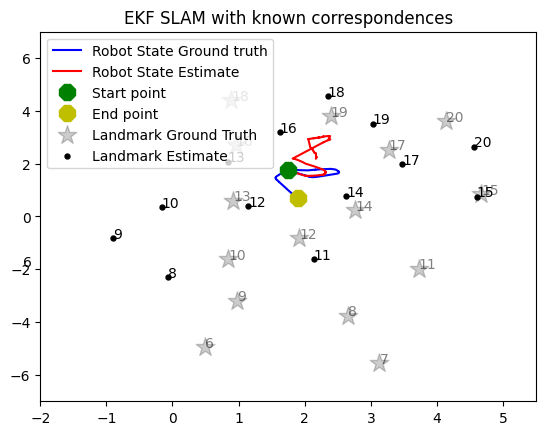

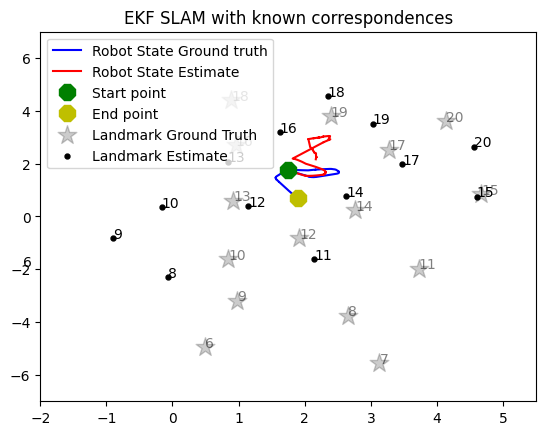

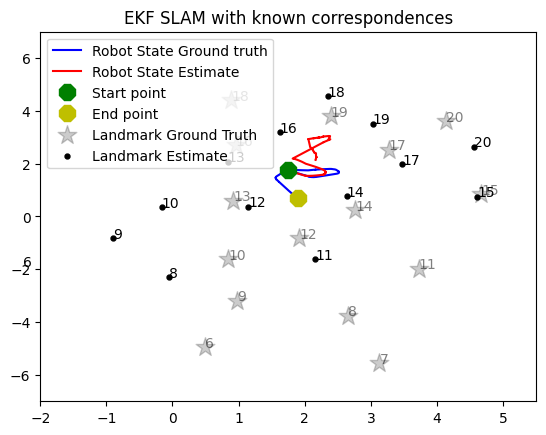

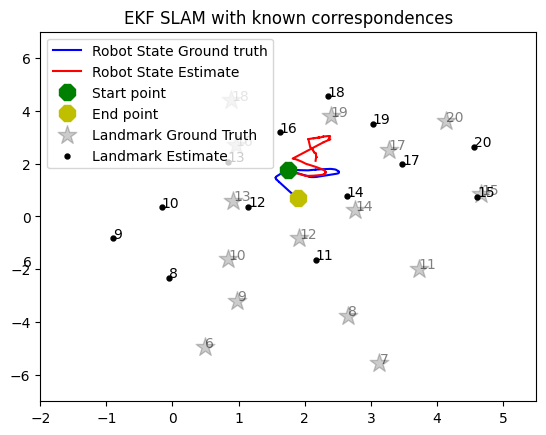

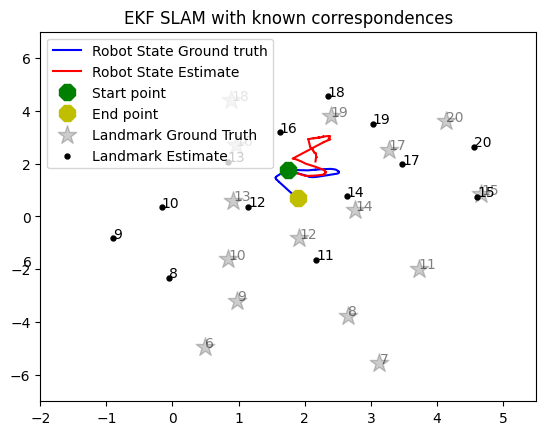

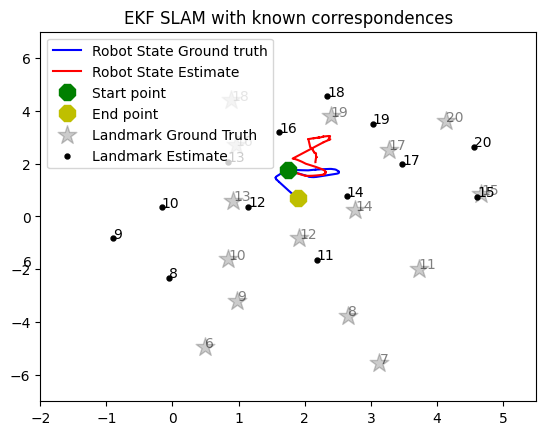

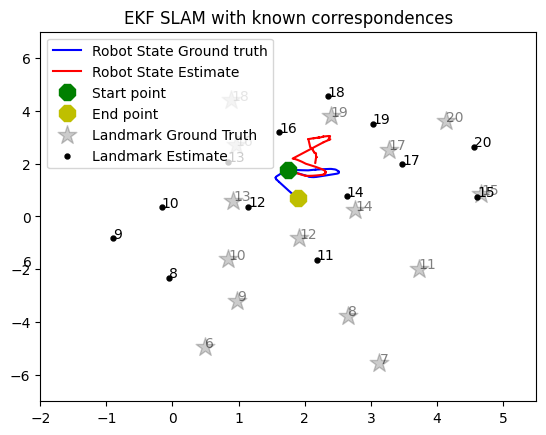

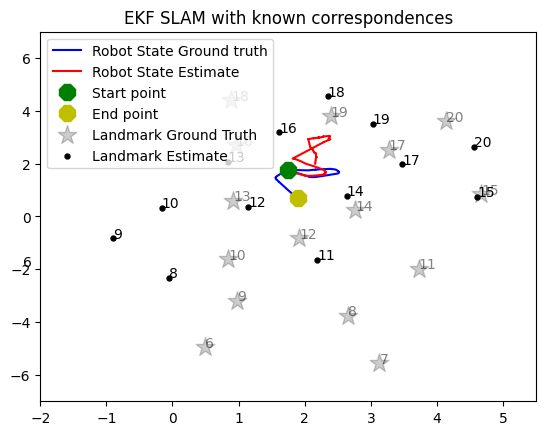

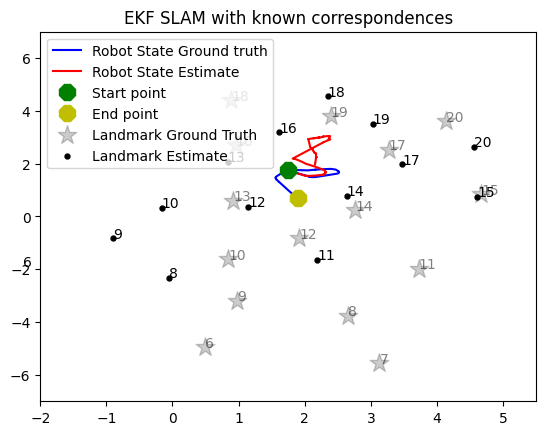

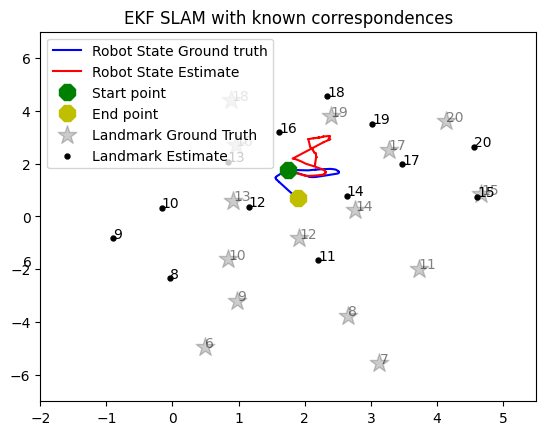

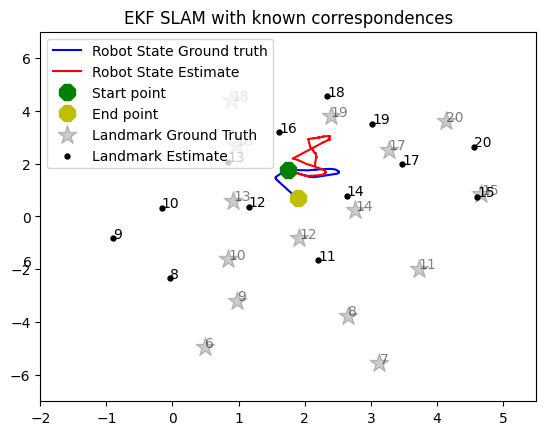

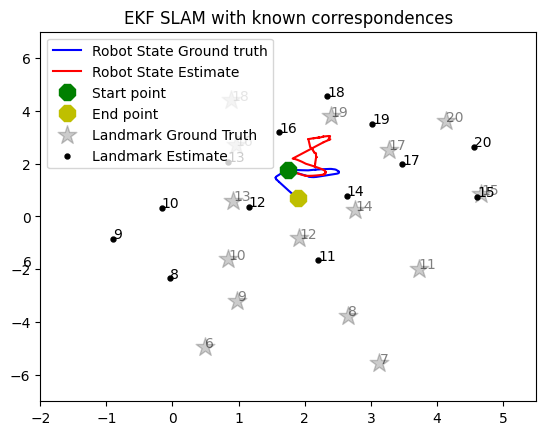

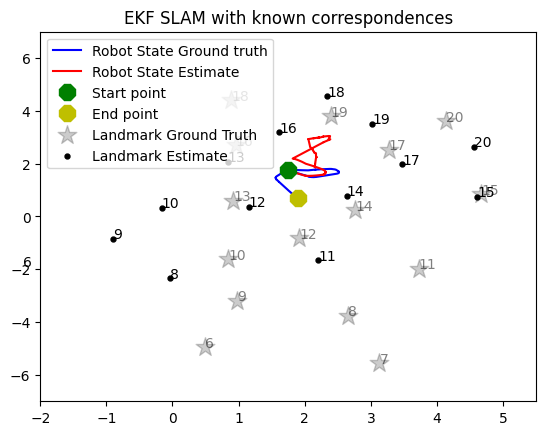

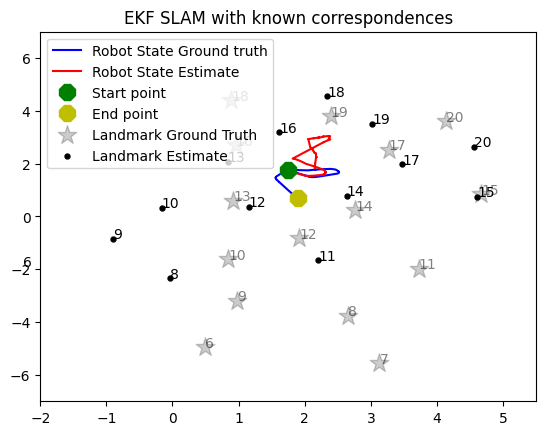

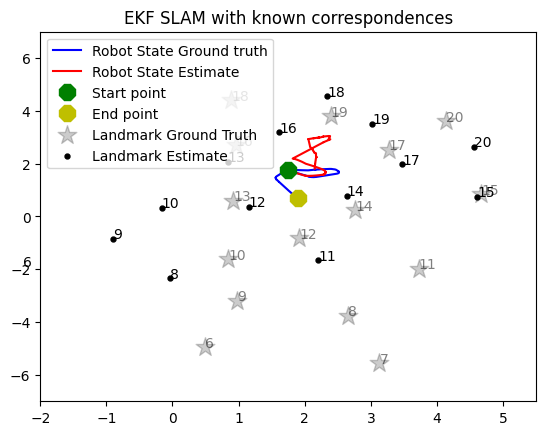

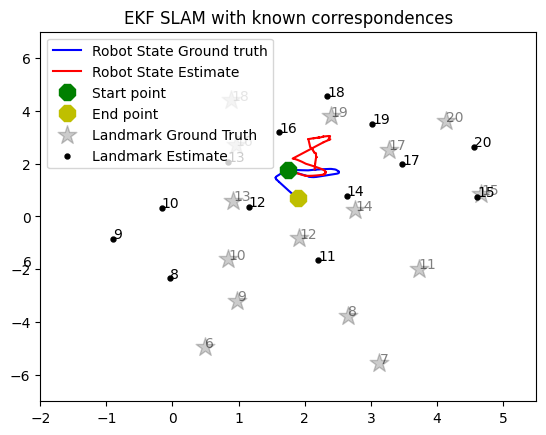

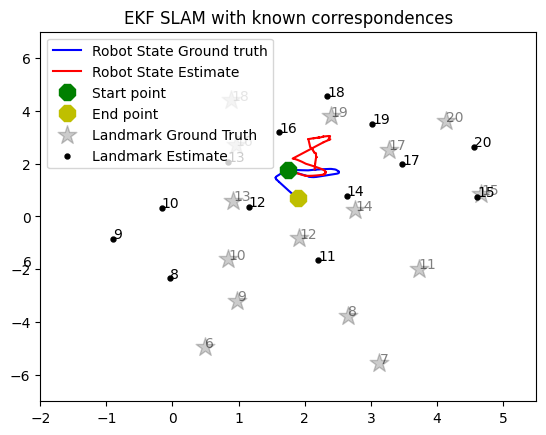

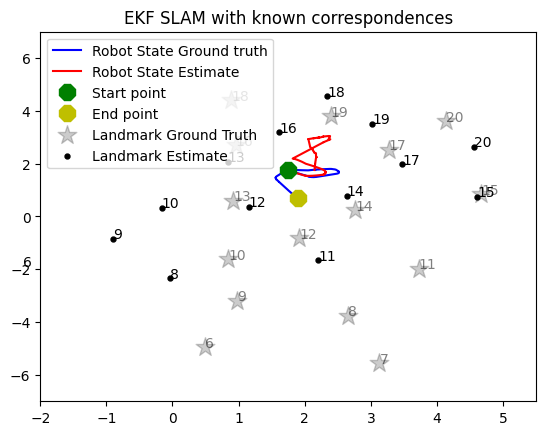

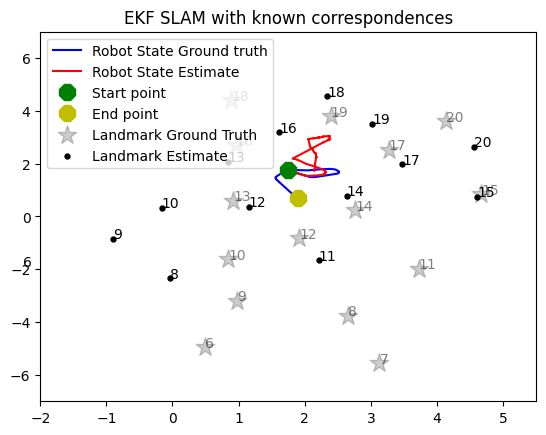

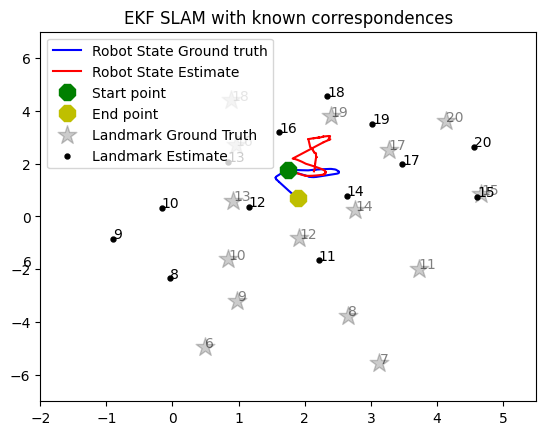

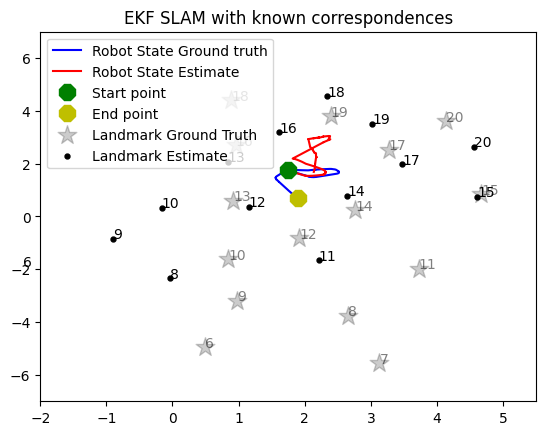

In [5]:
def ekf_slam_fn(dataset, robot, start_frame, end_frame, plot=True, plot_inter=False):
    # DEFAULT PARAMETERS:
    # State covariance matrix
    R = np.diagflat(np.array([5.0, 5.0, 100.0])) ** 2
    # Measurement covariance matrix
    Q = np.diagflat(np.array([300.0, 300.0, 1e16])) ** 2
    ekf_slam = EKF_SLAM(dataset, robot, start_frame, end_frame, R, Q, plot=plot, plot_inter=plot_inter)
    ekf_slam.build_dataframes()
    return ekf_slam
ekf_df = ekf_slam_fn(dataset, robot, start_frame, end_frame, plot=True, plot_inter=True)

**T11** Which type of SLAM problem is solving the EKF SLAM method executed above? Online or full? Why?

<span style=color:red>**Answer:**</span> The EKF SLAM algorithm applied above uses an online implementation. Hence, it simultaneosly estimates the current state, X<sub>t</sub> as it builds the map iteratively. The mesaurment_update() function takes into account already visited and new landmarks and updates the landmark states from the measurment errors. The motion_update() function is similar to EKF localization and based on only the last estimated state and control inputs.

**T12** Could you describe what hapens after a loop closure is detected?

<span style=color:red>**Answer:**</span> A loop closure takes place when the robot observes previously mapped landmarks. Loop closure helps the robot to propagate errors and be more certain about its state and landmark state estimations. In this case, in the measurment_update() function whenever a previously mapped landmark is observed, the error is calculated based on the known position of the landmark, instead of approximating it with respect to the robot's position. As a result, the measurement model provides more precise estimate of the landmark's position.

**T13** Which are the biggest limitations and advantages of the EKF SLAM? Justify your answer.

<span style="color:red">**Answer:**</span>
- **Limitations:** One of the biggest limitations of the EKF SLAM algorithm is the memory requirement - O(n<sup>2</sup>) - for building the covariance matrix. As the number of landmarks in the map grows, the memory consumption becomes a bottleneck. In addition, the copuational complexity for building the maps is also dependent on the map size. Besides, the estimations diverege while modelling non-linear environments.
- **Advantages:** Converges in case of linear gaussian environments and, for an averagely sized map the algorithm is good SLAM solution. Moreover, the algorithm provides a fundamental way for solving SLAM issues which is modified and used in other SLAM solutions as well. Additionally, the algorithm can be used for both online and full SLAM problems.

### T2. Review FAST SLAM
Review the FastSLAM() method, execute the FAST SLAM of the next code block, and answer the questions below:

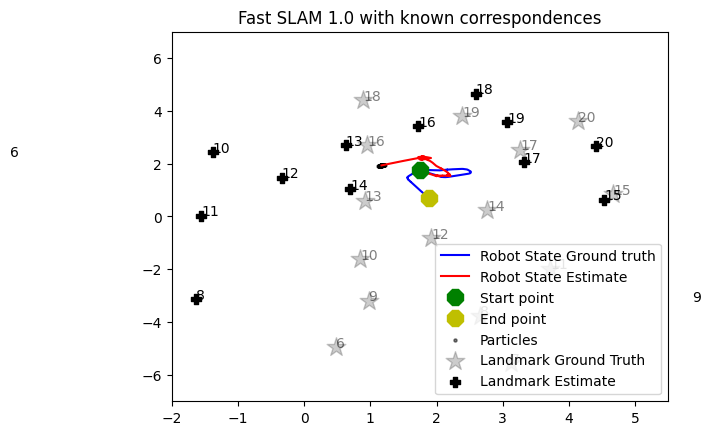

In [6]:
def fast_slam_fn(dataset, robot, start_frame, end_frame, N_particles = 100, plot = True):
    # Initialize Motion Model object
    # Motion noise (in meters / rad)
    # [noise_x, noise_y, noise_theta, noise_v, noise_w]
    # Fisrt three are used for initializing particles
    # Last two are used for motion update
    motion_noise = np.array([0.0, 0.0, 0.0, 0.1, 0.15])
    motion_model = FS_MotionModel(motion_noise)

    # Initialize Measurement Model object
    # Measurement covariance matrix
    Q = np.diagflat(np.array([0.05, 0.02])) ** 2
    measurement_model = FS_MeasurementModel(Q)

    # Initialize SLAM algorithm
    # Number of particles
    N_particles = N_particles

    fast_slam = FastSLAM(motion_model, measurement_model)
    fast_slam.load_data(dataset, robot, start_frame, end_frame)
    fast_slam.initialization(N_particles)

    # Run full Fast SLAM 1.0 algorithm
    for data in fast_slam.data:
        if (data[1] == -1):
            fast_slam.robot_update(data)
        else:
            fast_slam.landmark_update(data)
        fast_slam.state_update()
    if plot:
        fast_slam.plot_data()
        plt.show()
    fast_slam.build_dataframes()
    return fast_slam
fast_df = fast_slam_fn(dataset, robot, start_frame, end_frame)

**T2.1** The Fast SLAM algorithm iteratively executes the functions robot_update(), landmark_update() and state_update(). Could you specify, the objective of each of the functions?

<span style="color:red">**Answer:**</span>
- *robot_update()*: The robot_update() function in FastSLAM works similarly to the motion_update() of particle filter. Based on the control input (v, w) it estimates the state of each particle, however, with added gaussian noise.
- *landmark_update()*: Updates the robot particle weights and the covariance matrix for landmark mapping based on the EKF algorithm with the measurements data as input. Contrasting to the EKF SLAM's (n<sub>landmarks</sub>, n<sub>landmarks</sub>) the  covariance matrix has a dimension of (n<sub>landmarks</sub>, 2).
- *state_update()*: The state_update() function uses the state of each particle and landmark estimations to estimate the robot's state, and map. This is done by taking the average of all the states like in PF, and the landmark averages are weighted by how many particles observe some landmark.

**T2.2** The Fast SLAM algorithm method inputs a measurement_model. Could you describe the model and the purpose of it?

<span style="color:red">**Answer:**</span> The purpose of the measurement model is to update the state of the robot and landmarks' states based on the measurement data (range, bearing). If a new landmark is observed, the state of the landmark is initialized based on the current robot's states and the input. Also, importance weights for particles are assigned. If the landmark has already been observed, the error in range and bearing is used to approximate the landmark states with the EKF filter. 

**T2.3** Which is the main assumption of Fast SLAM algorithms?

<span style="color:red">**Answer:**</span> One important assumption for FastSLAM algorithm is that all the landmarks are conditionally independent given the robot's path, hence, the SLAM problem can be decoupled into robot path posterior and the landmark positions. However, in literature, this is said to be exact. Another assumption is that the FastSLAM algorithm will encounter unambiguous data once in a while for reliable data association.

### T3. Review Graph SLAM
Review the GraphSLAM() method, execute the Graph SLAM of the next code block, and answer the questions below:

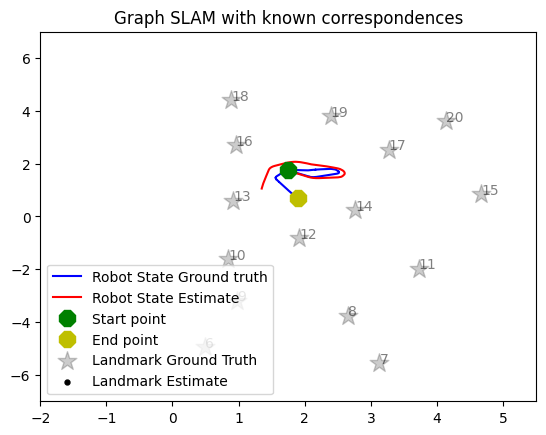

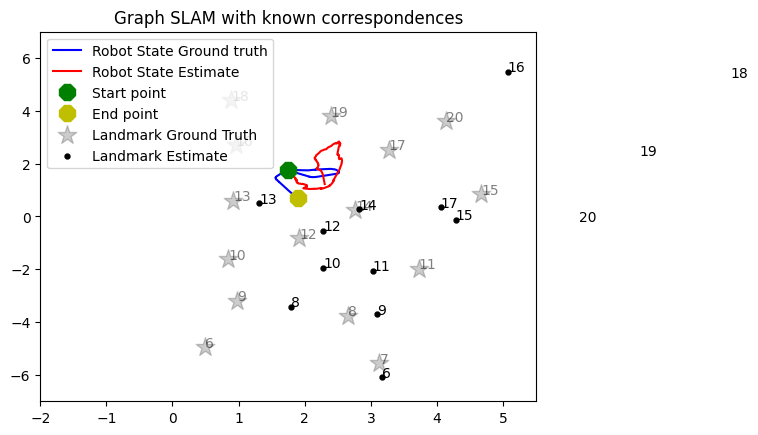

In [11]:
def graph_slam_fn(dataset, robot, start_frame, end_frame, n=4, plot=True):
    # State covariance matrix
    R = np.diagflat(np.array([5, 5, 20])) ** 2
    # Measurement covariance matrix
    Q = np.diagflat(np.array([100.0, 100.0, 1e16])) ** 2
    # Iterations
    n = n
    graph_slam = GraphSLAM(dataset, robot, start_frame, end_frame, n, R, Q, plot=plot)
    if plot:
        plt.show()
    graph_slam.build_dataframes()
    return graph_slam
graph_df = graph_slam_fn(dataset, robot, start_frame, end_frame, 1, plot=True)

**T3.1** Which type of SLAM problem is solving the Graph SLAM method executed above? Online or full? Why?

<span style="color:red">**Answer:**</span> The Graph SLAM implementation solves the full SLAM problem. After travelling from the start to the end point, the robot builds the graph as an information matrix and the corresponding information vector considering all state estimations and measurement inputs. Then, the graph optimization step is applied via the solve() function. This process is repeated few times for better map convergence. 

**T3.2** The main functions of the GraphSLAM() implementation executed above are: motion_update(), linearize(), reduce() and solve(). Justify for each function if it is part either from the front-end or the back end.

<span style="color:red">**Answer:**</span> 
- *motion_update()*: Front-end, Estimates the state based on the last state of the robot and the control inputs. Hence, contributes as a node for the graph.
- *linearize()*: Front-end, Based on all the control and measurement inputs builds and updates both the information matrix and the information vector. So, adds both the nodes and the constraints to the graph.
- *reduce()*: Back-end, Used to optimize the graph by reducing the dimensionality of the information matrix and vector by subtracting map constraints iteratively.
- *solve()*: Back-end, Solves the graph-optimization problem and calculates the final states estimations and the mean landmark locations from the matrix.

**T3.3** The GraphSLAM() implementation executed above shows a very poor performance in terms of computation. Please provide a list of suggestions to improve the efficiency of the implementation.

<span style="color:red">**Answer:**</span> Among the two phases of graph SLAM, the graph construction phase is similar in computational complexity as the other algorithms. Hence, the inefficiency comes from the graph-optimization phase due to the high dimensional information matrix. As the current implementation does not include the reduce() functionality, introducing that will improve the efficiency of the algorithm. As not all the robot states observe same landmarks, the subset of the poses can be adjusted based on these constraints and then these constraints can be removed from the information matrix. Thus, contributing in a compact information matrix/vector which should be much faster to solve.

### T4. Benchmark EKF, Fast and Graph SLAM
Compare the EKF, Fast and Graph SLAM using different datasets.
For the comparison use the error metrics introducced in previous lab sessions; the normalized accumulated error, the maximum error, and the final position error. 

The objective of this task is to be able to determine the SLAM algorithm that provides the best performance for this aplication. In order to decide which model and configuration works best follow the next steps:
1. Extract the error metrics for each dataset and model configuaration.
2. Represent the results in different types of plots (for instance catplot or correlation matrix).
3. Analyze the results and extract conclussions.

In [8]:
def normalized_path_error_optim(position_df):
    position = position_df.copy()
    position['x_delta'] = position["x_gt"].diff()
    position["y_delta"] = position["y_gt"].diff()
    position['x_delta'][0] = 0
    position['y_delta'][0] = 0
    position["weights"] = np.sqrt(position['x_delta']**2 + position["y_delta"]**2)
    position["path_error"] = np.sqrt(np.power(position["x_gt"] - position["x"], 2) + np.power(position["y_gt"] - position["y"], 2))
    position["e_path"] = (position["path_error"] * position["weights"]) / position["weights"].sum()

    e_path = position["e_path"].sum()
    e_max = np.max(position["path_error"])
    e_end = position["path_error"].iloc[-1]
    return e_path, e_max, e_end

#### Extract error metrics

In [9]:
datasets = ["data/MRCLAM_Dataset1",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4"]

robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

start_frame = 2000
end_frame = 5000

errors = pd.DataFrame(columns=['dataset', 'robot', 'identifier', 'type', 'acc?error','max_error','final_error','time'])

models = ['EKF_SLAM', 'FastSLAM', 'GraphSLAM']
idx = 1
for ds in datasets:
    for rob in robots:
        for md in models:
            identifier = f"d{ds[-1]}r{rob[-1]}"
            idx += 1
            st = None
            tic = time.perf_counter()
            if md == 'EKF_SLAM':
                st = ekf_slam_fn(ds, rob, start_frame, end_frame, plot=False, plot_inter=False)
            elif md == 'FastSLAM':
                N_particles = 100
                st = fast_slam_fn(ds, rob, start_frame, end_frame, N_particles, plot = False)
            elif md == 'GraphSLAM':
                # Build Particle Filter object
                n = 4
                st = graph_slam_fn(ds, rob, start_frame, end_frame, n, plot=False)
            toc = time.perf_counter()
            joint_df = pd.DataFrame(st.robot_states).join(st.gt, rsuffix = '_gt').dropna()
            try:
                e_path, e_max, e_end = normalized_path_error_optim(joint_df)
            except:
                print(joint_df)
            errors.loc[-1] = [ds, rob, identifier, md, e_path, e_max, e_end, toc-tic]
            errors.index = errors.index + 1  # shifting index
            errors = errors.sort_index()

#### Represent metrics

In [10]:
errors.head()

dataset   robot identifier       type  acc?error  max_error  \
0  data/MRCLAM_Dataset4  Robot4       d4r4  GraphSLAM  33.964361  51.351700   
1  data/MRCLAM_Dataset4  Robot4       d4r4   FastSLAM   0.583444   1.562088   
2  data/MRCLAM_Dataset4  Robot4       d4r4   EKF_SLAM   0.604887   1.566089   
3  data/MRCLAM_Dataset4  Robot3       d4r3  GraphSLAM   0.409442   0.857114   
4  data/MRCLAM_Dataset4  Robot3       d4r3   FastSLAM   0.303942   0.443760   

   final_error       time  
0    35.335153  49.181841  
1     1.562088   8.529024  
2     1.019715   0.363669  
3     0.856984  44.580473  
4     0.443760  10.339036

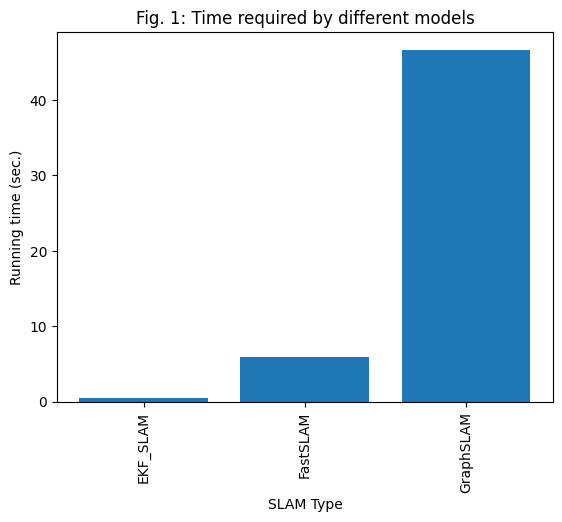

In [20]:
plt.bar(np.arange(errors['type'].nunique()), errors.groupby('type')['time'].mean())
plt.xticks(np.arange(errors['type'].nunique()), errors.groupby('type').groups.keys(), rotation=90)
plt.xlabel("SLAM Type")
plt.ylabel("Running time (sec.)")
plt.title("Fig. 1: Time required by different models")
plt.show()

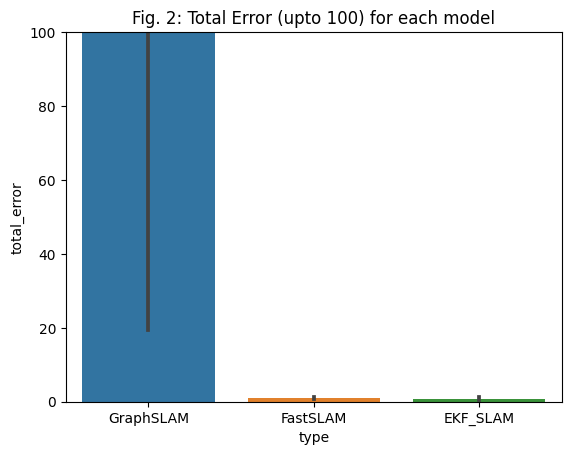

In [22]:
df = pd.DataFrame(zip(errors['acc?error']  + errors['max_error'] + errors['final_error'], errors['time'], errors['type'], errors['identifier']), columns = ['total_error', 'time', 'type', 'identifier'])
f = sns.barplot(df, x='type', y='total_error')
f.set(ylim=(0,100))
plt.title('Fig. 2: Total Error (upto 100) for each model')
plt.show()

In [28]:
graph_error = errors[errors['type'] == 'GraphSLAM']
slam_error = errors[errors['type'] != 'GraphSLAM']

# Graph SLAM

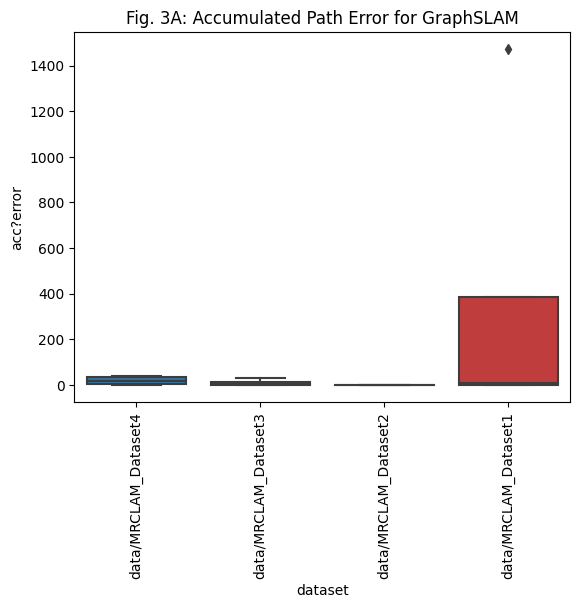

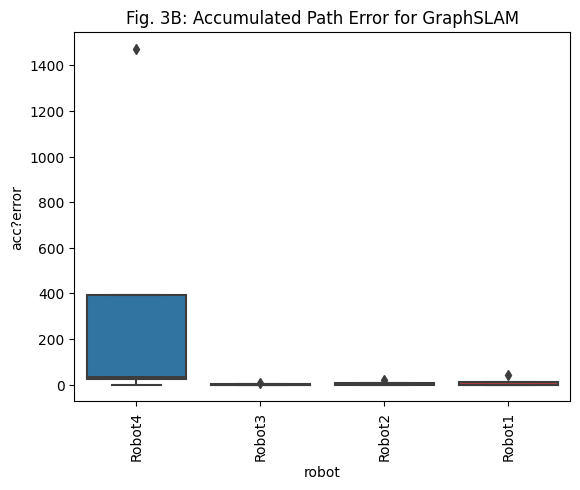

In [43]:
sns.boxplot(graph_error, x ='dataset', y='acc?error')
plt.title('Fig. 3A: Accumulated Path Error for GraphSLAM')
plt.xticks(rotation=90)
plt.show()
sns.boxplot(graph_error, x ='robot', y='acc?error')
plt.title('Fig. 3B: Accumulated Path Error for GraphSLAM')
plt.xticks(rotation=90)
plt.show()

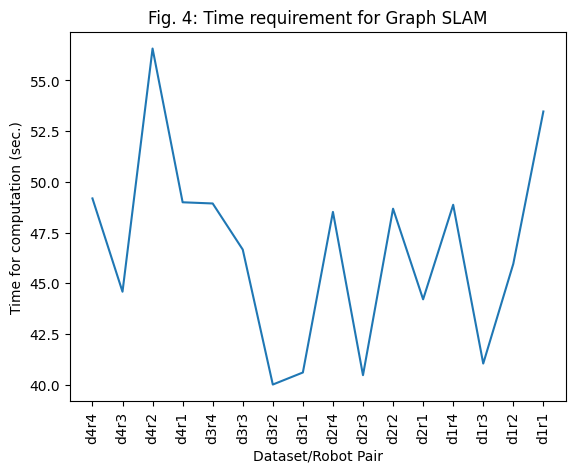

In [47]:
plt.plot(np.arange(graph_error.shape[0]), graph_error['time'])
plt.xticks(np.arange(graph_error.shape[0]), graph_error['identifier'], rotation=90)
plt.xlabel("Dataset/Robot Pair")
plt.ylabel("Time for computation (sec.)")
plt.title("Fig. 4: Time requirement for Graph SLAM")
plt.show()

# EKF & Fast SLAM

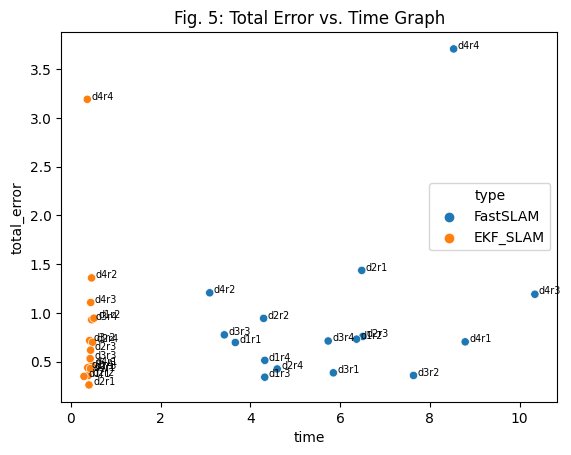

In [63]:
df = pd.DataFrame(zip(slam_error['acc?error']  + slam_error['max_error'] + slam_error['final_error'], slam_error['time'], slam_error['type'], slam_error['identifier']), columns = ['total_error', 'time', 'type', 'identifier'])
f = sns.scatterplot(df, hue='type', x='time', y='total_error')
for _, dfr in df.iterrows():
    plt.text(dfr['time']+0.09, dfr['total_error'], dfr['identifier'], fontsize = 'x-small')
plt.title('Fig. 5: Total Error vs. Time Graph')
plt.show()

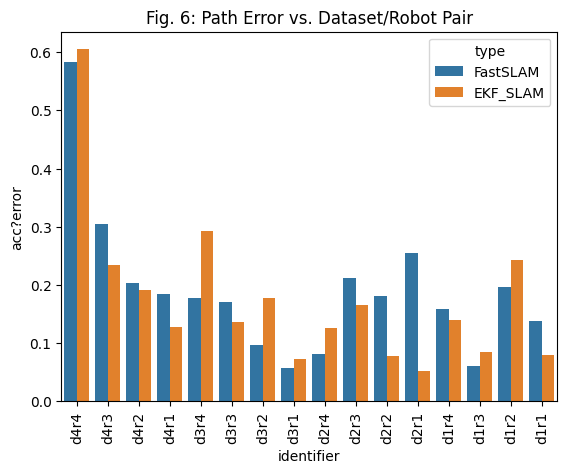

In [68]:
f=sns.barplot(data=slam_error, x="identifier", y="acc?error", hue="type")
plt.title('Fig. 6: Path Error vs. Dataset/Robot Pair')
plt.xticks(rotation=90)
plt.show()

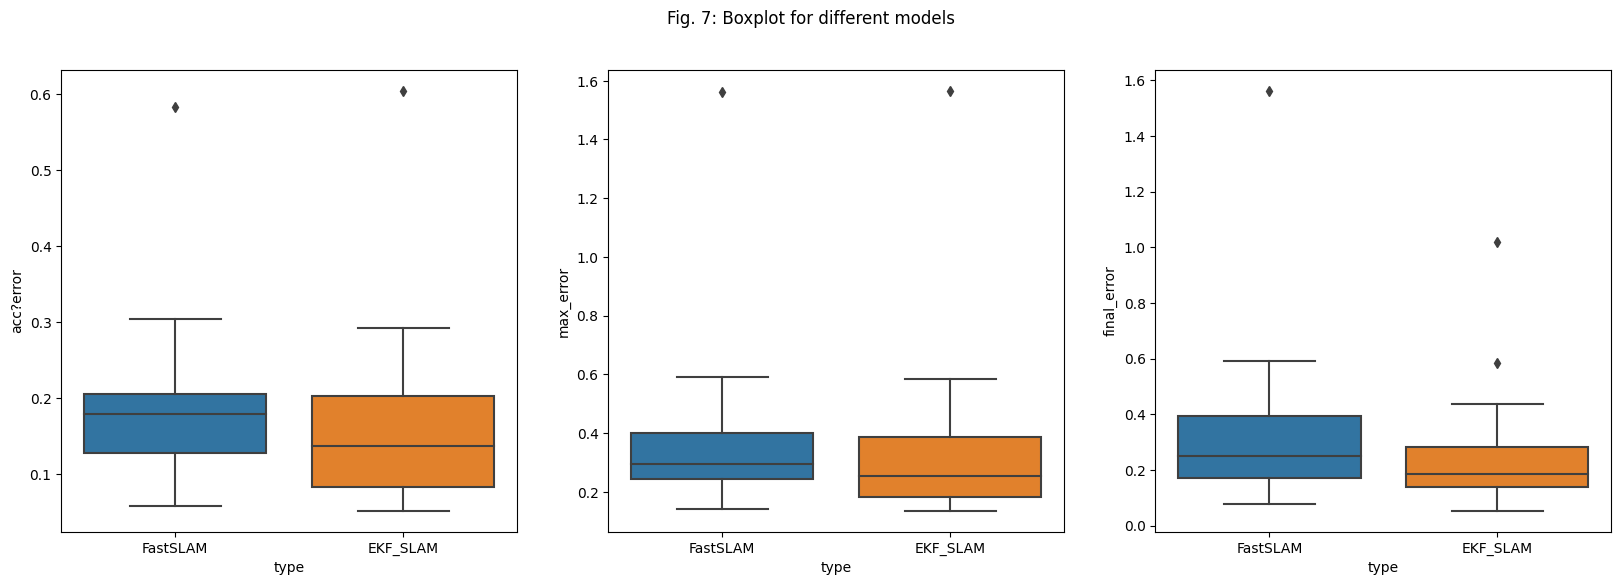

In [67]:
# Represent metrics for all experiments
f, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(slam_error, x='type', y='acc?error', ax=axes[0])
sns.boxplot(slam_error, x='type', y='max_error', ax=axes[1])
sns.boxplot(slam_error, x='type', y='final_error', ax=axes[2])

f.suptitle("Fig. 7: Boxplot for different models")
plt.show()

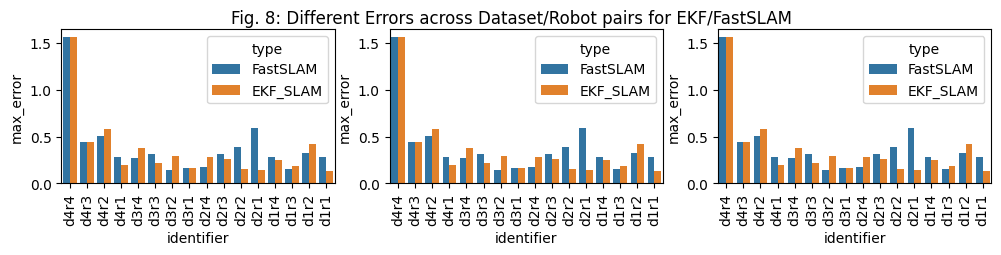

In [74]:
er_type = ['acc?error', 'max_error', 'final_error']
figure = plt.figure(figsize=(12,2))
for e in er_type:
    plt.subplot(130 + int(er_type.index(e))+1)
    sns.barplot(slam_error, hue='type', y='max_error', x='identifier')
    plt.xticks(rotation=90)
plt.suptitle("Fig. 8: Different Errors across Dataset/Robot pairs for EKF/FastSLAM")
plt.show()

#### Analize metrics
**T4.1** Analize the representations, and extract some conclusions regarding the performance of each of SLAM implementation. In case we need to integrate a navigation algorithm based on SLAM to the robots used for recording the datasets, which method would you use? Justify your answer.


(Answer here max 300 words)

**T4.2** Could you list the the three algorithms ordered in terms of robustness? Justify your answer.

<span style=colr:red>**Answer:**</span> 

### T5. ORB SLAM 3


**T5.1** Which is the difference between VO and VSLAM algorithms?

(Answer here max 150 words)

**T5.2** Which is the difference between direct and indirect SLAM methods?

(Answer here max 150 words)

**T5.3** Which are the main differences between the visual, iisual-inertial, and multimap SLAM methods?

(Answer here max 150 words)

**T5.4** Can you provide a brief description of the four main system components?

(Answer here max 150 words)

**T5.5** Which is the benefit of using an inertial sensor?

(Answer here max 150 words)

**T5.6** Which kinds of environments will work best for ORB SLAM 3?

(Answer here max 150 words)

### Delivery
Download the file in Notebook and Markdown formats to be uploaded in the Aula Digital.

To export the files go to File>Download as>Notebook and File>Download as>Markdown.

Save the files as **E2_name_surname.ipynb** and **E2_name_surname.md**

Compress files and figures in the same directory with the name **E2_name_surname.zip**

**Deadline 2022-11-25**